# Feature Descriptor and Projective Geometry

In this notebook, we explore different stages to establish robust image correspondences.

## Task 1 - Compare ORB and SIFT descriptor (2P)

Load the two given images (box.png and box_in_scene.png) and convert them to grayscale.
Use OpenCVs SIFT and ORB implementation to detect and compute feature descriptors and match the keypoints from box.png against box_in_scene.png.
Filter matches below a ratio of 0.7 between the first and second best match and show the results in an image.
Measure and print the time detection, computation and matching takes for each of the descriptors (nothing else).
What difference do you see in the computation time and in the visual matching results?


Useful functions:
* cv.SIFT_create()
* cv.ORB_create()
* cv.BFMatcher() (take care what normType you use)
* cv.BFMatcher().knnMatch (to get more than just the best match)
* cv.drawMatchesKnn
* time.time()

SIFT Time: 0.057153 seconds
ORB Time: 0.007510 seconds
SIFT Matching Time: 0.006005 seconds
ORB Matching Time: 0.003521 seconds


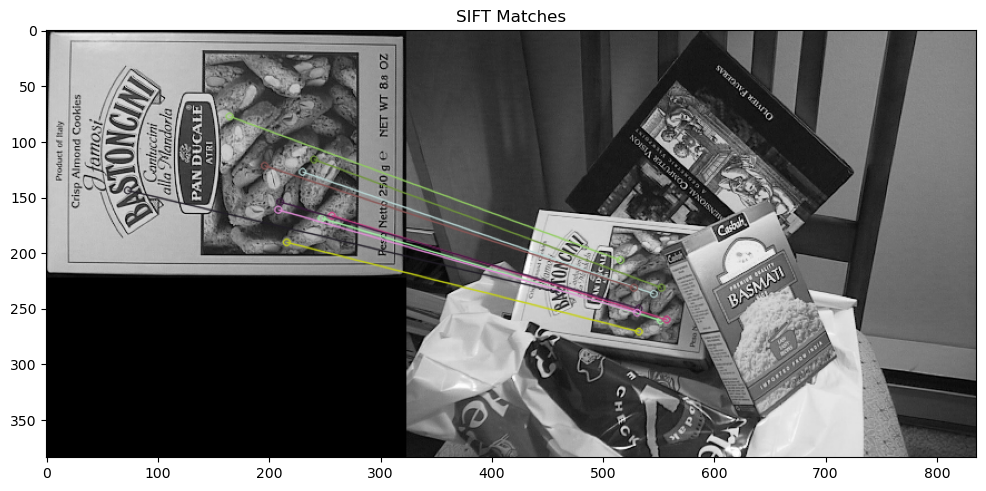

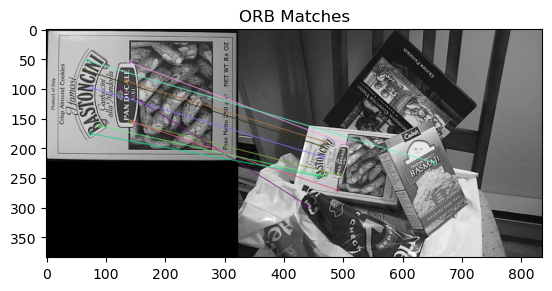

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

def loadImage(path, resizeFactor):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape[:2]  # Get the height and width from the first two elements
    image = cv2.resize(image, (int(width * resizeFactor), int(height * resizeFactor)))
    return image

image = loadImage("box.png", 1)
image2 = loadImage("box_in_scene.png", 1)



sift = cv2.SIFT_create()
orb = cv2.ORB_create()

start_time = time.time()
kp_sift, d_sift = sift.detectAndCompute(image, None)
kp_scene_sift, d_scene_sift = sift.detectAndCompute(image2, None)
sift_time = time.time() - start_time

start_time = time.time()
kp_orb, d_orb = orb.detectAndCompute(image, None)
kp_scene_orb, d_scene_orb = orb.detectAndCompute(image2, None)
orb_time = time.time() - start_time

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

start_time = time.time()
matches_sift = bf.match(d_sift, d_scene_sift)
matches_sift = sorted(matches_sift, key = lambda x: x.distance)
sift_matching_time = time.time() - start_time

good_matches_sift = []
ratio = 0.7
for match in matches_sift:
    if match.distance < ratio * match.distance:
        good_matches_sift.append(match)

img_matches_sift = cv2.drawMatches(image, kp_sift, image2, kp_scene_sift, matches_sift[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

start_time = time.time()
matches_orb = bf.match(d_orb, d_scene_orb)
matches_orb = sorted(matches_orb, key=lambda x: x.distance)
orb_matching_time = time.time() - start_time

good_matches_orb = []
for m in matches_orb:
    if m.distance < ratio * m.distance:
        good_matches_orb.append(m)

img_matches_orb = cv2.drawMatches(image, kp_orb, image2, kp_scene_orb, matches_orb[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

print(f"SIFT Time: {sift_time:.6f} seconds")
print(f"ORB Time: {orb_time:.6f} seconds")
print(f"SIFT Matching Time: {sift_matching_time:.6f} seconds")
print(f"ORB Matching Time: {orb_matching_time:.6f} seconds")

# Display the images using matplotlib
plt.figure(figsize=(12, 6))


plt.imshow(img_matches_sift)
plt.title('SIFT Matches')
plt.show()

plt.imshow(img_matches_orb)
plt.title('ORB Matches')
plt.show()


## Task 2 - Project 3D world points onto an image (1P)

Draw a 3D bounding box on top of the given image (car.jpg). Only use matrix multiplications until you arrive at the homogeneous coordinates. Show the result image.

Given Data:

Bounding Box coordinates in object/world space:

$x_{min} = -1.01916409\\
x_{max} = 1.01916695\\
y_{min} = 0.0116795003\\
y_{max} = 1.45007753\\
z_{min} = -1.98612642\\
z_{max} = 2.28453016$  

Object Pose:

$R_{cw} =  \\
0.781443774, -0.0168506317, 0.623748242 \\ 
-0.40051806, -0.780070364, 0.480703056  \\
0.478467345, -0.625464856, -0.616330147$  


$t_{cw} = [-0.248362243, 0.000240437686, 11.415081]^T$  

Camera intrinsics:

$f \cdot s_x = f \cdot s_y = 532.569458$  
$x_c = 320, y_c = 240$

Useful functions:
* numpy.mat or numpy.array for matrix multiplications
* cv.line

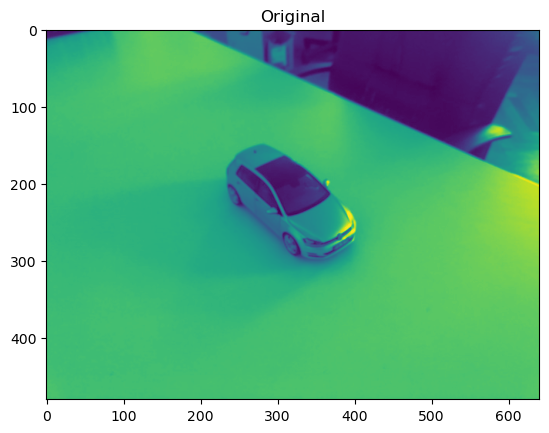

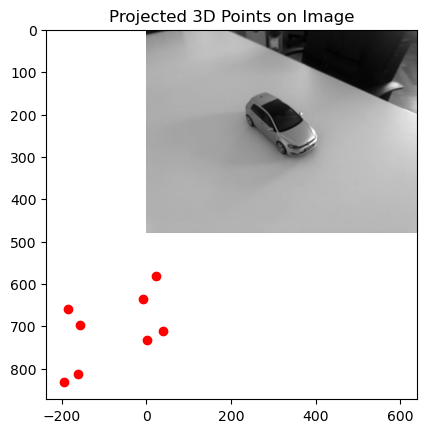

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

def loadImage(path, resizeFactor):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape[:2]  # Get the height and width from the first two elements
    image = cv2.resize(image, (int(width * resizeFactor), int(height * resizeFactor)))
    return image

image = loadImage("car.jpg", 1)

#Bounding Box coordinates in object/world space:

xmin = -1.01916409
xmax = 1.01916695
ymin = 0.0116795003
ymax = 1.45007753
zmin = -1.98612642
zmax = 2.28453016 

#Object Pose:

R_cw =  np.array([[0.781443774,-0.0168506317, 0.623748242],
         [-0.40051806, -0.780070364, 0.480703056],
          [0.478467345, -0.625464856, -0.616330147]])


t_cw = np.array([-0.248362243, 0.000240437686, 11.415081])

# Camera intrinsics
f_sx = f_sy = 532.569458
cx = 320
cy = 240

# Camera intrinsic matrix
K = np.array([[f_sx, 0, cx],
              [0, f_sy, cy],
              [0, 0, 1]])

R_wt = R_cw.T
t_wc = -R_wt @ t_cw

P = K @ np.hstack((R_wt, t_wc.reshape(3,1)))

points_3d = np.array([[xmin, ymin, zmin],
                      [xmax, ymin, zmin],
                      
                      [xmin, ymax, zmin],
                      [xmax, ymax, zmin],
                      
                      [xmin, ymin, zmax],
                      [xmax, ymin, zmax],
                      
                      [xmin, ymax, zmax],
                      [xmax, ymax, zmax]])

points_3d_homogenous =  np.hstack((points_3d, np.ones((8, 1))))

points_2d_homogenous = P @ points_3d_homogenous.T
points_2d_homogenous /= points_2d_homogenous[2, :] 

points_2d = points_2d_homogenous[:2, :].T

plt.imshow(image)
plt.title('Original')
plt.show()

plt.imshow(image, cmap='gray')
plt.scatter(points_2d[:, 0], points_2d[:, 1], color='red')
plt.title('Projected 3D Points on Image')
plt.show()

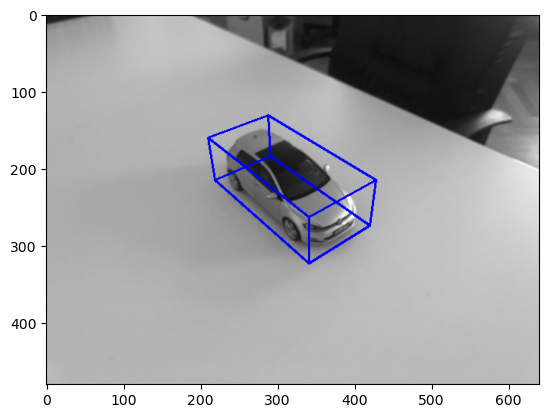

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Given data
xmin, xmax = -1.01916409, 1.01916695
ymin, ymax = 0.0116795003, 1.45007753
zmin, zmax = -1.98612642, 2.28453016

# Object pose
R_cw = np.array([[0.781443774, -0.0168506317, 0.623748242],
                 [-0.40051806, -0.780070364, 0.480703056],
                 [0.478467345, -0.625464856, -0.616330147]])

t_cw = np.array([-0.248362243, 0.000240437686, 11.415081])

# Camera intrinsics
f_sx = f_sy = 532.569458
xc, yc = 320, 240

# Define 3D bounding box coordinates
points_3d = np.array([[xmin, ymin, zmin],
                      [xmax, ymin, zmin],
                      [xmax, ymax, zmin],
                      [xmin, ymax, zmin],
                      [xmin, ymin, zmax],
                      [xmax, ymin, zmax],
                      [xmax, ymax, zmax],
                      [xmin, ymax, zmax]])

# Apply object pose
points_cw = R_cw @ points_3d.T + t_cw.reshape(-1, 1)

# Apply camera intrinsics
points_image = np.array([
    [f_sx * point[0] / point[2] + xc, f_sy * point[1] / point[2] + yc]
    for point in points_cw.T
])

# Draw the 3D bounding box on the image
image = cv2.imread("car.jpg")
for i in range(4):
    cv2.line(image, tuple(map(int, points_image[i])), tuple(map(int, points_image[(i + 1) % 4])), (0, 0, 255), 2)
    cv2.line(image, tuple(map(int, points_image[i + 4])), tuple(map(int, points_image[(i + 1) % 4 + 4])), (0, 0, 255), 2)
    cv2.line(image, tuple(map(int, points_image[i])), tuple(map(int, points_image[i + 4])), (0, 0, 255), 2)

# Show the result image
plt.imshow(image)
plt.show()